In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.tsa.stattools import ccovf,ccf
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.graphics.tsaplots import month_plot,quarter_plot, seasonal_plot


In [2]:
test_set_start_date = pd.to_datetime('2019-12-01')
prediction_period = 7

In [3]:
def model_metrics(y_true, predictions, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)
    mea = mean_absolute_error(y_true=y_true, y_pred=predictions)

    return pd.DataFrame(data = [{'Model': model_name, 'rmse': rmse, 'r2': r2, 'mea' : mea}])

### Data Preparation

In [4]:
restaurant_data = pd.read_csv('Data/AggData.csv', index_col=0, infer_datetime_format=True)
restaurant_data.index = pd.to_datetime(restaurant_data.index)
restaurant_data = restaurant_data.asfreq(pd.infer_freq(restaurant_data.index))
restaurant_data['DoW'] = restaurant_data.index.day_of_week

### EDA

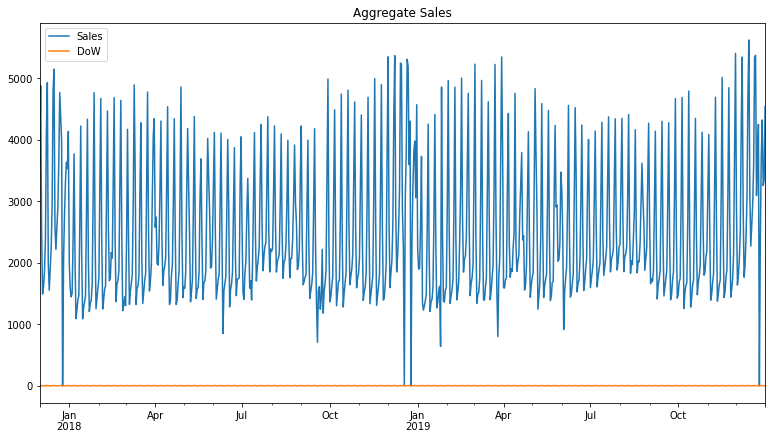

In [5]:
restaurant_data.plot(figsize = (13,7), legend=True, title = 'Aggregate Sales');

##### Seasonal Decomposition on the whole training data set

<AxesSubplot:>

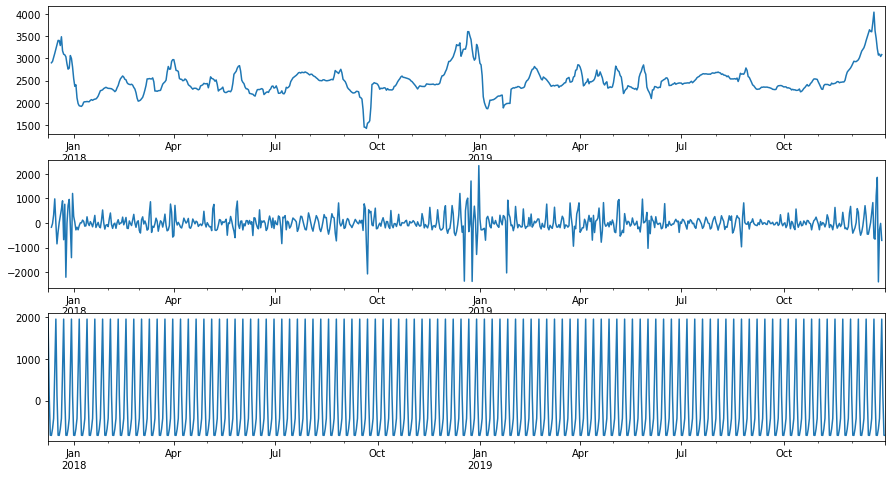

In [41]:
decomposed_data = seasonal_decompose(restaurant_data.Sales)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposed_data.trend.plot(ax=ax1)
decomposed_data.resid.plot(ax=ax2)
decomposed_data.seasonal.plot(ax=ax3)

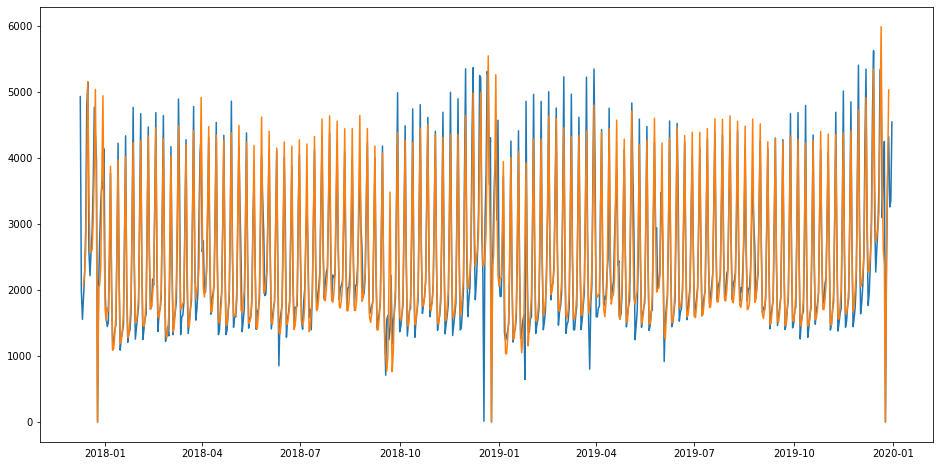

In [52]:
estimated = decomposed_data.trend + decomposed_data.seasonal
estimated['2018-12-25'] = 0
estimated['2017-12-25'] = 0
estimated['2019-12-25'] = 0
plt.figure(figsize=(16,8), )
plt.plot(restaurant_data.Sales)
plt.plot(estimated)
plt.title = 'Estimated VS Actual'
plt.legend = True
plt.show();

##### Seasonal decomposition on only 60 days

<AxesSubplot:>

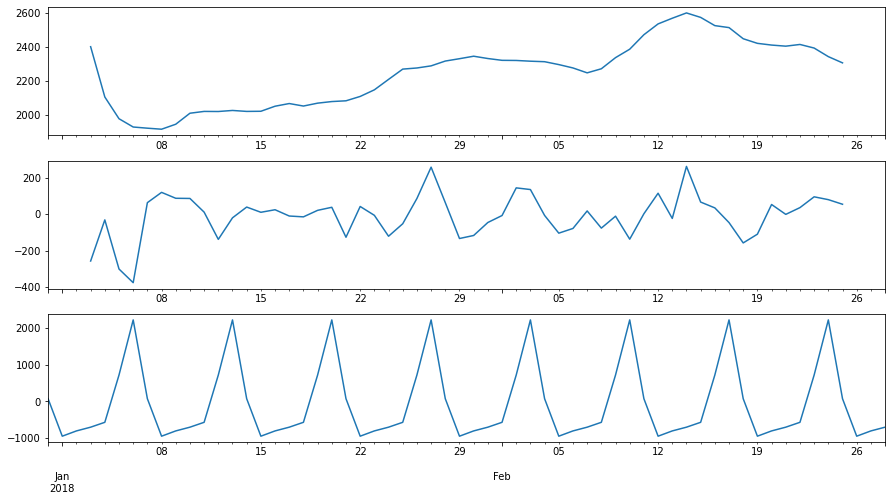

In [10]:
decomposed_data = seasonal_decompose(restaurant_data.Sales[30:90])
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposed_data.trend.plot(ax=ax1)
decomposed_data.resid.plot(ax=ax2)
decomposed_data.seasonal.plot(ax=ax3)

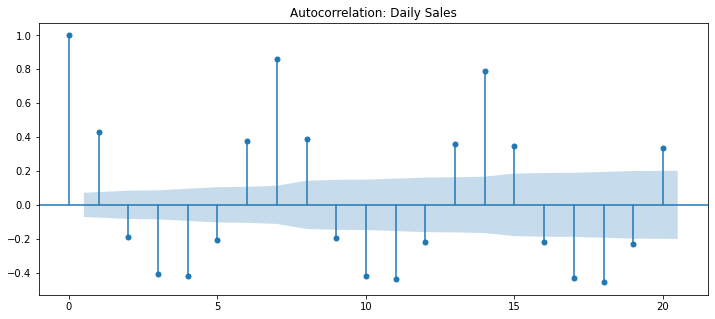

In [54]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Daily Sales'
lags = 20
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(restaurant_data.Sales,title=title,lags=lags, ax=ax);

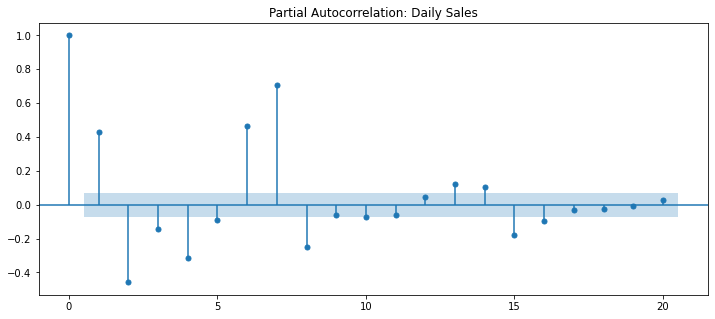

In [55]:
title='Partial Autocorrelation: Daily Sales'
lags=20
fig,ax = plt.subplots(figsize=(12,5))
plot_pacf(restaurant_data.Sales,title=title,lags=lags, ax = ax);

### Tests for Stationarity

In [14]:
print('Augmented Dickey-Fuller Test on Sales Data')
dftest = adfuller(restaurant_data['Sales'],autolag='AIC')
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Sales Data
ADF test statistic       -3.788631
p-value                   0.003026
# lags used              20.000000
# observations          740.000000
critical value (1%)      -3.439218
critical value (5%)      -2.865454
critical value (10%)     -2.568854
dtype: float64


Here we have a very low p-value at 0.003, which provides strong evidence against the null hypothesis, and so we <em> reject</em> the null hypothesis, and decide that our dataset is stationary.<br>

### Exposing Seasonality with Month and Quarter Plots

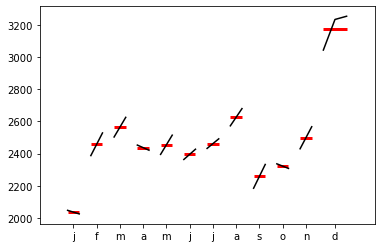

In [15]:
month_plot(restaurant_data['Sales'].resample(rule = 'M').mean());

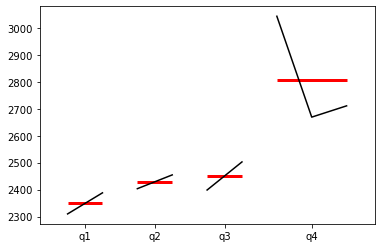

In [16]:
dfq = restaurant_data['Sales'].resample(rule='Q').mean()

quarter_plot(dfq);

### Stationarity: take first difference of this series

In [17]:
restaurant_data['FirstDifference'] = restaurant_data.Sales.diff().dropna()
restaurant_data = restaurant_data.dropna()

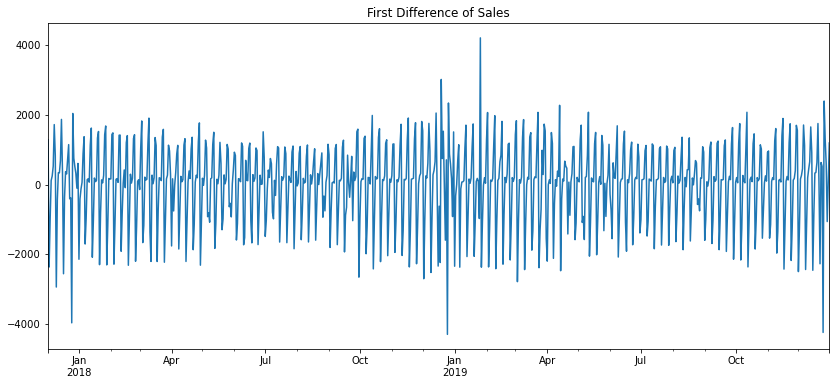

In [23]:
restaurant_data.FirstDifference.plot(figsize = (14,6), title='First Difference of Sales');

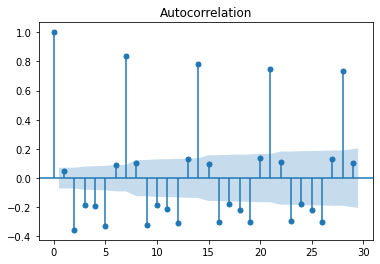

In [24]:
plot_acf(restaurant_data.FirstDifference);

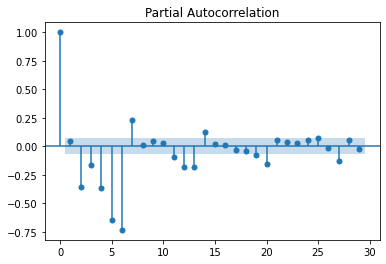

In [26]:
plot_pacf(restaurant_data.FirstDifference);

### Removing seasonality

In [27]:
restaurant_data['NonSeasonalSales'] = restaurant_data.Sales.diff(7)
restaurant_data = restaurant_data.dropna()

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

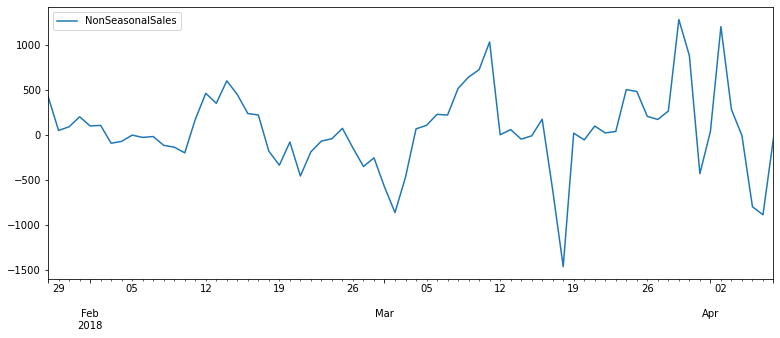

In [32]:
restaurant_data.NonSeasonalSales[50:120].plot(figsize = (13,5), legend = True)

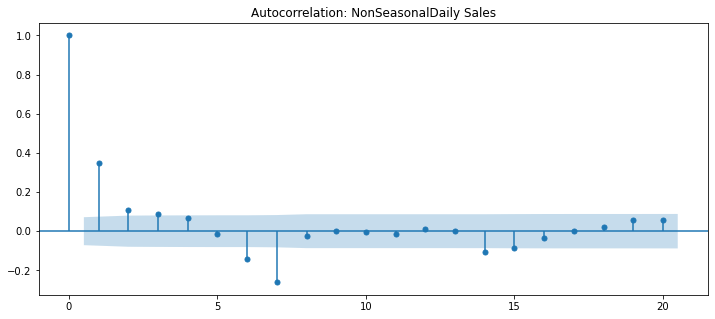

In [59]:
title='Autocorrelation: NonSeasonalDaily Sales'
lags=20
fig,ax = plt.subplots(figsize=(12,5))
plot_acf(restaurant_data.NonSeasonalSales,title=title,lags=lags, ax = ax);

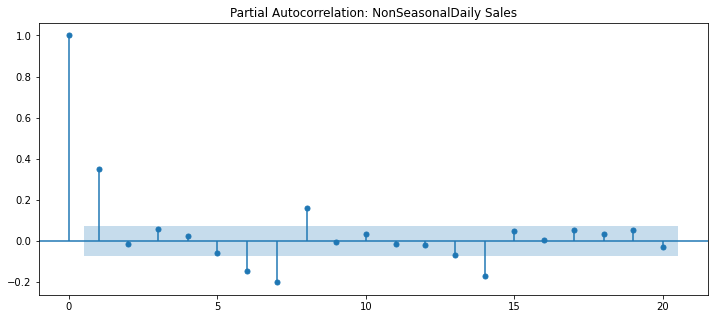

In [58]:
title='Partial Autocorrelation: NonSeasonalDaily Sales'
lags=20
fig,ax = plt.subplots(figsize=(12,5))
plot_pacf(restaurant_data.NonSeasonalSales,title=title,lags=lags, ax = ax);

### Anomaly detection

In [60]:
resid_mu = decomposed_data.resid.mean()
resid_dev = decomposed_data.resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

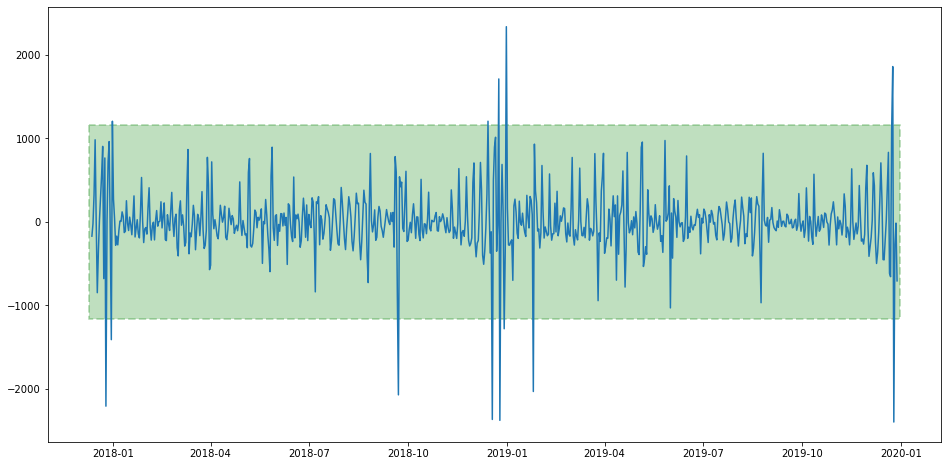

In [65]:
plt.figure(figsize=(16,8))
plt.plot(decomposed_data.resid)
plt.fill_between([restaurant_data.index.min(), restaurant_data.index.max()], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)

In [66]:
anomalies = restaurant_data.Sales[(decomposed_data.resid < lower) | (decomposed_data.resid > upper)]

In [67]:
anomalies

2017-12-25       0.000000
2017-12-30    3531.086797
2017-12-31    4137.734706
2018-09-22    1411.054959
2018-12-14    5248.950677
2018-12-18      11.849143
2018-12-24    4305.189479
2018-12-25       0.000000
2018-12-29    3979.210313
2018-12-31    4570.940833
2019-01-25     643.259420
2019-12-24    4249.768016
2019-12-25       0.000000
Name: Sales, dtype: float64

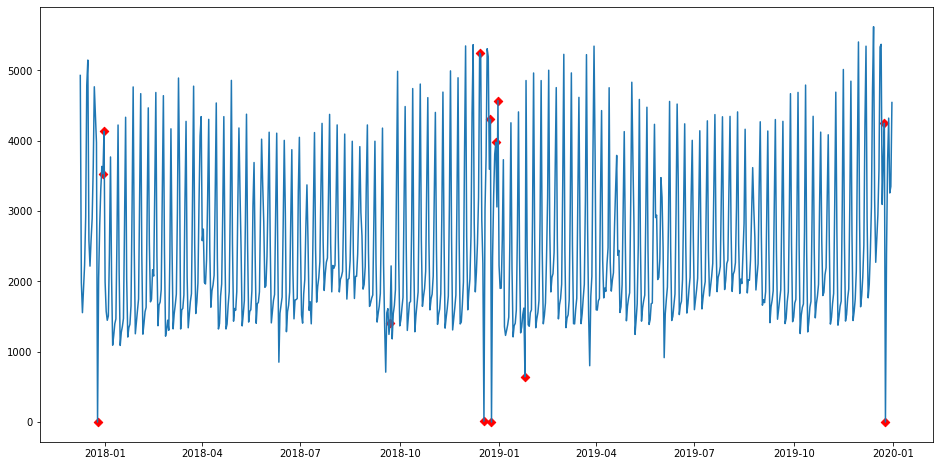

In [74]:
plt.figure(figsize=(16,8))
plt.plot(restaurant_data.Sales)
plt.scatter(anomalies.index, anomalies, color='r', marker='D')